Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train_master = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test_master = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
from sklearn.model_selection import train_test_split
train_percent = 0.75
def reset_train(train_percent):
  train,val = train_test_split(train_master,train_size=train_percent,stratify = train_master['status_group'],random_state=26)
  return train,val
train,val = reset_train(train_percent)
test=test_master
train.shape,val.shape, test.shape



((44550, 41), (14850, 41), (14358, 40))

In [4]:
import numpy as np

In [5]:
def wrangle(X):
  #Prevent set with copy warning
  X= X.copy()

  #Latitude has small values around 3 (noise in data should be 0)
  #replace small values with 0
  X['latitude'] = X['latitude'].replace(-2e-08,0)

  #When there are zeroes for long and lat they should be np.nan
  cols_with_zeroes = ['longitude','latitude']
  for col in cols_with_zeroes:
    X[col] = X[col].replace(0,np.nan)

  #quantity and quantity_group are duplicates (drop one)
  X = X.drop(columns='quantity_group')

  #return wrangled data frame
  return X 
  
train = wrangle(train_master)
val = wrangle(val)
test = wrangle(test_master)

##Select Features:

In [6]:
#Set Target
target = 'status_group'

#Set Features:

#A Dataframe with just the features
train_features = train.drop(columns=[target,'id'])

#List of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# I don't want cat variables with high cardinality:
cardinality = train_features.select_dtypes(exclude='number').nunique()

#get a list of the categorical features:
categorical_features = cardinality[cardinality<=50].index.tolist()

#combine lists for features used in model

features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [7]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

## Using Pipelines


In [8]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators =50,
                           n_jobs = -2,
                           max_features= 30,
                           random_state = 26,
                           min_samples_leaf=10,
                           criterion='entropy')
)

#fitting the above model
pipeline.fit(X_train,y_train)

#accuracy scores
print('Train Accuracy',pipeline.score(X_train,y_train))
print('Validation Accuracy',pipeline.score(X_val,y_val))

Train Accuracy 0.8567508417508417
Validation Accuracy 0.8565656565656565


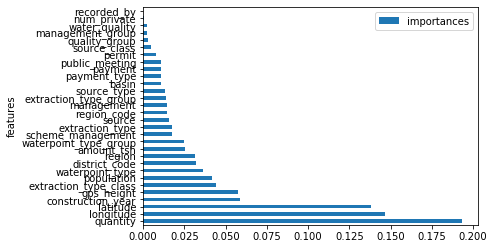

In [51]:
import matplotlib.pyplot as plt
#lets look at feature importances first

feature_import = pd.DataFrame(data=[X_train.columns, pipeline.named_steps['randomforestclassifier'].feature_importances_])
feature_import = feature_import.T
feature_import.columns = ['features','importances']
feature_import = feature_import.sort_values('importances',ascending=False)
# feature_import.head()
feature_import.plot.barh('features','importances')


In [81]:
#I have to encode the X_val before I can put it through
encoder = pipeline.named_steps['ordinalencoder']
X_val_encoded=encoder.transform(X_val)
X_val_encoded.head()


,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
10234,50.0,204,38.352132,-6.635096,0,6,1,30,2006,7,...,3,3,1,1,1,7,7,2,1,1
55455,500.0,1463,34.630308,-8.967258,0,11,4,45,2003,8,...,7,7,1,1,1,7,7,2,1,1
44641,0.0,1242,37.973017,-4.436926,0,3,3,140,2010,3,...,2,2,1,1,2,1,1,1,1,1
40096,0.0,0,33.314178,-3.795302,0,17,3,0,0,5,...,2,2,1,1,4,6,6,1,3,2
38429,0.0,0,33.835076,-3.611908,0,17,8,0,0,5,...,4,4,1,1,3,7,7,2,2,1


In [86]:
# encoder mappings
encoder.mapping[1]["col"]

'region'

In [102]:
output_classes = list(y_train.unique())

['functional', 'non functional', 'functional needs repair']

(<Figure size 1080x1080 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x28703e57f48>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x28709d9b6c8>,
   <matplotlib.axes._subplots.AxesSubplot at 0x28704845488>]})

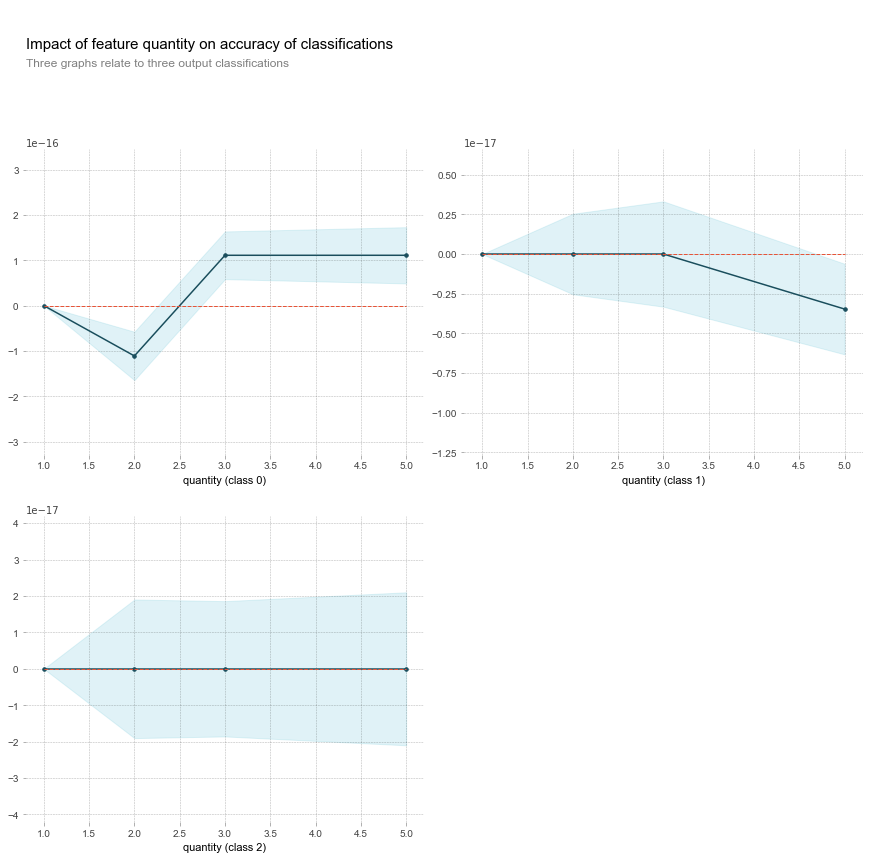

In [114]:
#lets find the partial importances of quantity
from pdpbox.pdp import pdp_isolate,pdp_plot

feature = 'quantity'

isolated = pdp_isolate(
    model=pipeline,
    dataset = X_val_encoded,
    model_features = X_val.columns,
    feature = feature
)

output_classes = list(y_train.unique())

pdp_plot(isolated,feature,
#          which_classes = [0],
         plot_params = {
            'title':f'Impact of feature {feature} on accuracy of classifications',
            'subtitle':'Three graphs relate to three output classifications'
            }
        )


In [ ]:
#I'm getting three graphs instead of 1 because my y_values are 
#categories for classification instead of a predicted value, 
#the graphs still make sense, but if I wanted one graph I could specify
#a specific output class  with the which_class parameter. I still need 
#to figure out how to specify a class label instead of an integer for this list
